# PG

In [2]:
from dataset import HallucinationDataset
from torch.utils.data import DataLoader

data = HallucinationDataset("data/val/val.model-aware.v2.json", "PG")
loader = DataLoader(data, batch_size=5)

In [84]:
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

model_name = 'tuner007/pegasus_paraphrase'

torch_device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
pegasus = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

def get_response(input_text, num_return_sequences, num_beams, temperature=1.5):
  batch = tokenizer(input_text, truncation=True, padding='max_length',max_length=60, return_tensors="pt").to(torch_device)
  paraphrased = pegasus.generate(**batch,max_length=60, num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=temperature, do_sample=True)
  f_1_hyp = tokenizer.batch_decode(paraphrased, skip_special_tokens=True)
  return f_1_hyp

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
for batch in loader:
    print(get_response(batch["hyp"], 1, 8, temperature=3.))
    print(batch["hyp"])
    break

["Please don't get involved in those attempts if you are.", 'The meeting will happen on Friday and the vote on a later date should also happen on that day.', 'Iraq has become a more important player in the agenda in the past few weeks.', 'Turkey does not hesitate to fulfill its obligations.', 'It is a momentous achievement.']
['If you are involved in these attempts, please stay out of it.', 'The debate on Friday and the vote on a later date should be kept as per the agenda.', 'Iraq has become more and more prominent on the international agenda over the past few weeks.', 'Turkey has a lot of obligations of its own.', 'The achievement of enlargement is historic.']


In [22]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-distilroberta-base-v1')

In [8]:
from torch.nn.functional import cosine_similarity, cross_entropy

preds = []
labels = []

device = "cuda:1"
model.to(device)

def calculate_acc(preds, label, thr=0.85):
    return (label == (preds > thr).int()).float().mean()

for batch in train_loader:
    hyp = model.encode(batch["hyp"], convert_to_tensor=True)
    src = model.encode(batch["src"], convert_to_tensor=True)
    label = batch["label"]
    pred = cosine_similarity(hyp, src).cpu().detach()

    preds.extend(pred.numpy())
    labels.extend(label.numpy())

    # ce.append(cross_entropy(pred, label.float()))
    # acc.append((calculate_acc(pred, label)))

In [48]:
from scipy.stats import spearmanr

spearmanr(labels, preds)

SignificanceResult(statistic=0.15294957267239603, pvalue=0.08858989636902173)

0.808


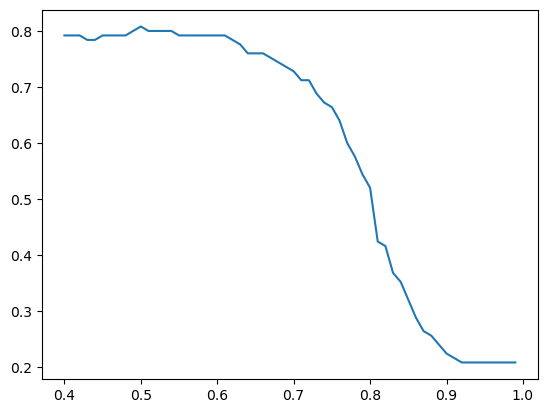

In [49]:
import numpy as np
from matplotlib import pyplot as plt

accuracy_lst = []

for threshold in np.arange(0.4, 1.0, 0.01):
    answers = [int(value) for value in np.array(preds) > threshold]
    accuracy_lst.append((np.array(labels) == np.array(answers)).mean())

print(max(accuracy_lst))

plt.plot(np.arange(0.4, 1.0, 0.01), accuracy_lst)

### consistency similarity

In [111]:
def get_preds(temp):
    preds = []
    labels = []
    
    device = "cuda:1"
    model.to(device)
    
    for batch in train_loader:
        f_1_hyp = model.encode(get_response(batch["hyp"], 1, 8, temp), convert_to_tensor=True)
        src = model.encode(batch["src"], convert_to_tensor=True)
        label = batch["label"]
        pred = cosine_similarity(f_1_hyp, src).cpu().detach()
    
        preds.extend(pred.numpy())
        labels.extend(label.numpy())

    print(spearmanr(labels, preds))

    accuracy_lst = []
    
    for threshold in np.arange(0.3, 1.0, 0.01):
        answers = [int(value) for value in np.array(preds) > threshold]
        accuracy_lst.append((np.array(labels) == np.array(answers)).mean())
    
    print(max(accuracy_lst))
    
    plt.plot(np.arange(0.3, 1.0, 0.01), accuracy_lst)

SignificanceResult(statistic=0.16715203299197565, pvalue=0.06243800793067133)
0.816


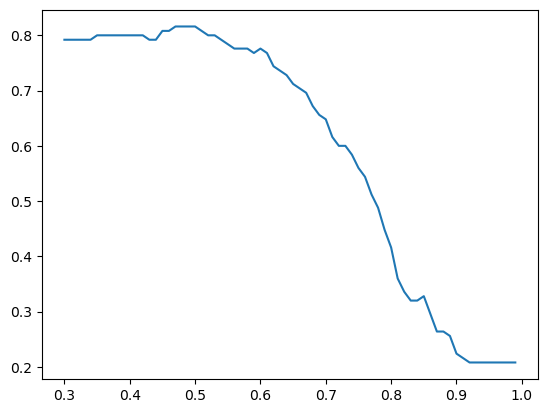

In [119]:
get_preds(0.5)

SignificanceResult(statistic=0.09450098597258753, pvalue=0.29450651683802864)
0.816


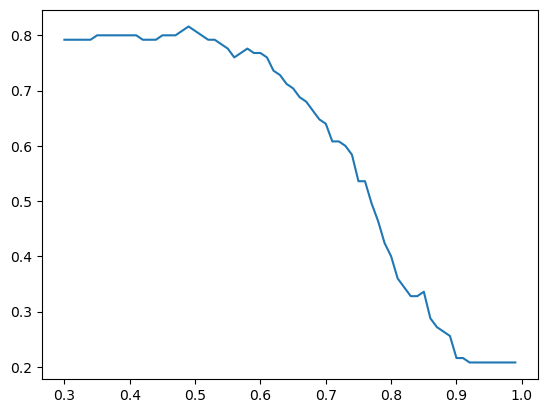

In [118]:
get_preds(1.)

### Better results:

SignificanceResult(statistic=0.18627072957602517, pvalue=0.03753584794825341)
0.824


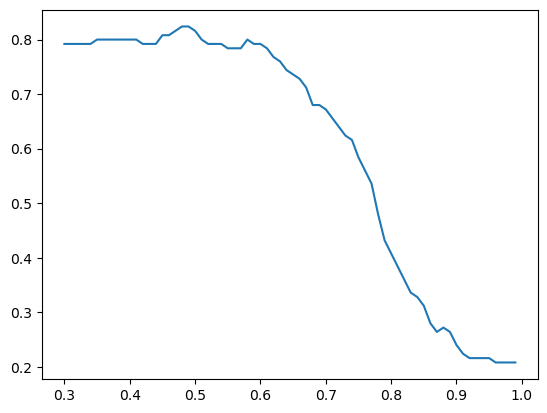

In [113]:
get_preds(1.5)

SignificanceResult(statistic=0.08521476191747779, pvalue=0.3447208329652619)
0.792


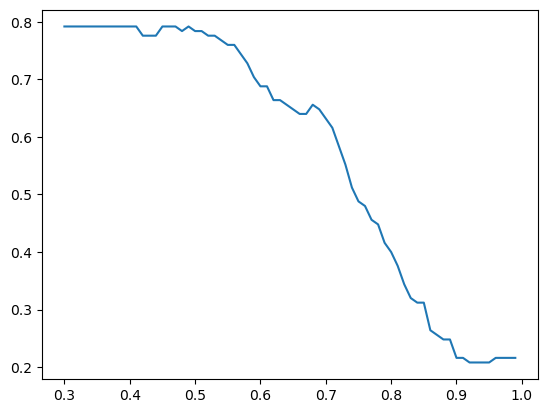

In [114]:
get_preds(2.)

SignificanceResult(statistic=0.19828819600028488, pvalue=0.02664244404791342)
0.808


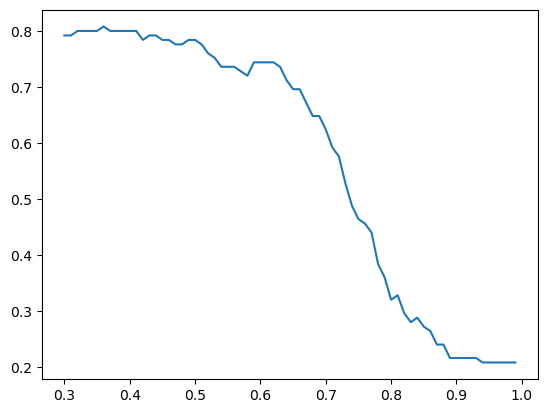

In [115]:
get_preds(2.5)

SignificanceResult(statistic=0.14857958488175615, pvalue=0.09819380885638537)
0.792


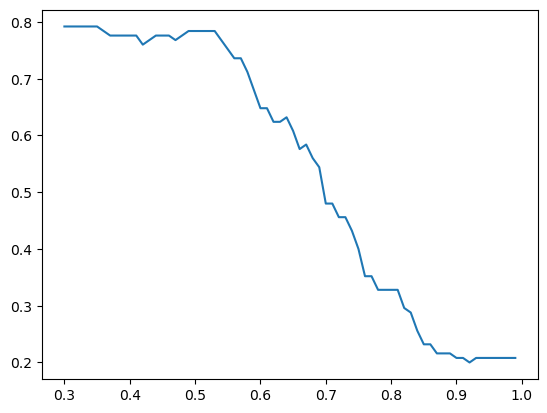

In [116]:
get_preds(3.)

SignificanceResult(statistic=0.09941722223705743, pvalue=0.2699893759915187)
0.76


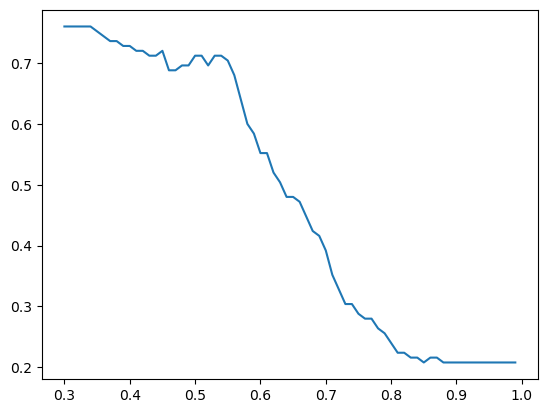

In [117]:
get_preds(4.)

### baselines

In [99]:
import numpy as np

preds = np.array([0.5] * len(labels)) + np.random.normal(size=len(labels))
spearmanr(labels, preds)

SignificanceResult(statistic=-0.02348868437468939, pvalue=0.7948567754863701)

In [74]:
preds = [0.5] * (len(labels) -1) + [0.52]

In [75]:
spearmanr(labels, preds)

SignificanceResult(statistic=0.0460212313053112, pvalue=0.6103078937702286)

# MT

In [72]:
from dataset import HallucinationDataset
from torch.utils.data import DataLoader

data = HallucinationDataset("data/val/val.model-aware.v2.json", "MT")
loader = DataLoader(data, batch_size=5)

In [83]:
for b in loader:
    print(b["src"])
    print(b["hyp"])
    break

['ريبوان واكتو نڠ لالو, سوراڠ لاكيان باڠاران أريستارحوس ماۑامبات أمون سيستيم تاتا سوريا باڬاراك ماڠاليليڠي ماتاهاري.', '1980-се йылдарҙа ул «Такси”, “Ура” һәм “Трейси Уллман шоуы” кеүек шоуҙар өҫтөндә эшләй.', 'अलगाव आ पुनर्संयोजन प्रत्येक पीढ़ीक संग द्विटा पूल सभक बीच फेरबदल भिन्नता कें आगू-पाछू करैत रहैत अछि।', 'Rolando Mendoza yakoreshe imbunda ya M16 yari afite arasa ba mukerarugendo.', 'Zi geɖe la, dekɔnu toto yeye aɖe menɔlawo dea dzesi wo ɖokuiwo to dzeside-tsyiãwo siwo lɔ awudodoƒomeviwo, agbenɔnɔ aɖewo ƒomevi kpakple gbegbɔgblɔ tɔxɛ aɖe si gɔme woawo ɖeɖe se la ɖe me.']
['Over the course of time, a number of aristocratic powers overran the entire Syriac system in order to control the deaths.', 'In the 1980s, he worked on shows such as the Taxi Show, the Urback Show, and the Tracy Ullman Show.', 'Separation and reintegration continue to shift the differences between the two pools with each generation.', 'Rolando Mendoza used an M16 rifle with a very high-powered armour.', 'Ofte

In [86]:
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M", src_lang="auto")
translator = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M").to(device)

batch = ['Rolando Mendoza yakoreshe imbunda ya M16 yari afite arasa ba mukerarugendo.']

inputs = tokenizer(batch, truncation=True, padding='max_length',max_length=30, return_tensors="pt").to("cuda:1")

translated_tokens = translator.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id["eng_Latn"], max_length=30)
tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)

['Rolando Mendoza used an M16 rifle with a cartridge.']

In [70]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

def translate(batch):
    inputs = tokenizer(batch, truncation=True, padding='max_length',max_length=30, return_tensors="pt").to("cuda:1")
    
    translated_tokens = translator.generate(
        **inputs, forced_bos_token_id=tokenizer.lang_code_to_id["eng_Latn"], max_length=30
    )
    return tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)

def get_preds_mt():
    preds = []
    labels = []
    
    device = "cuda:1"
    model.to(device)
    translator.to(device)
    
    for batch in loader:
        f_src = model.encode(translate(batch["src"]), convert_to_tensor=True)

        hyp = model.encode(batch["hyp"], convert_to_tensor=True)
        label = batch["label"]
        pred = cosine_similarity(f_src, hyp).cpu().detach()
    
        preds.extend(pred.numpy())
        labels.extend(label.numpy())

    print(spearmanr(labels, preds))

    accuracy_lst = []
    
    for threshold in np.arange(0.3, 1.0, 0.01):
        answers = [int(value) for value in np.array(preds) > threshold]
        accuracy_lst.append((np.array(labels) == np.array(answers)).mean())
    
    print(max(accuracy_lst))
    
    plt.plot(np.arange(0.3, 1.0, 0.01), accuracy_lst)

## model-agnostic

### Sentence transformer

In [24]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M", src_lang="eng_Latn")
translator = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

In [39]:
from sentence_transformers import SentenceTransformer

def get_preds_mt(mode):
    src_lang = "eng_Latn" if mode == "en->ru" else "rus_Cyrl"
    tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M", src_lang=src_lang)
    translator = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

    if mode == "ru->en":
        model = SentenceTransformer('sentence-transformers/paraphrase-distilroberta-base-v1')
    else:
        model = SentenceTransformer('DeepPavlov/rubert-base-cased-sentence')

    def translate(batch):
        lang = "rus_Cyrl" if mode == "en->ru" else "eng_Latn"
        inputs = tokenizer(batch, truncation=True, padding='max_length',max_length=30, return_tensors="pt").to("cuda:1")
        
        translated_tokens = translator.generate(
            **inputs, forced_bos_token_id=tokenizer.lang_code_to_id[lang], max_length=30
        )
        return tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)

    preds = []
    labels = []
    
    device = "cuda:1"
    model.to(device)
    translator.to(device)
    
    for i, batch in enumerate(loader):
        src = batch["src"]
        hyp = batch["hyp"]

        if mode == "en->ru":
            if not i: print(hyp)
            hyp = translate(hyp)
        else:
            if not i: print(src)
            src = translate(src)
        if not i: print(src, hyp)
        

        src = model.encode(src, convert_to_tensor=True)
        hyp = model.encode(hyp, convert_to_tensor=True)

        label = batch["label"]
        pred = cosine_similarity(src, hyp).cpu().detach()
    
        preds.extend(pred.numpy())
        labels.extend(label.numpy())

    print(spearmanr(labels, preds))

    accuracy_lst = []
    
    for threshold in np.arange(0.3, 1.0, 0.01):
        answers = [int(value) for value in np.array(preds) > threshold]
        accuracy_lst.append((np.array(labels) == np.array(answers)).mean())
    
    print(max(accuracy_lst))
    
    plt.plot(np.arange(0.3, 1.0, 0.01), accuracy_lst)

In [29]:
data = HallucinationDataset("data/val/val.model-agnostic.json", "MT")
loader = DataLoader(data, batch_size=5)

### Eng -> rus

No sentence-transformers model found with name /home/petrushina/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased-sentence. Creating a new one with MEAN pooling.


['John and John are the only one of them.', 'How about Tom and French? - "Not bad."', "I think that's why you need to dress up.", 'I would be Canadian!', 'The classmates called Tom.']
['Джон и Энн нравятся друг другу.', 'Как у Тома с французским? - "Неплохо".', 'Я думаю, Тому нужно переодеться.', 'Был бы я канадец!', 'Одноклассники обзывали Тома.'] ['Джон и Джон - единственные из них.', '- Что насчет Тома и Франца?', 'Думаю, именно поэтому тебе нужно одеваться.', 'Я бы был канадцем!', 'С одноклассники позвонили Тому.']
SignificanceResult(statistic=0.4237704473884538, pvalue=1.5096822588299775e-09)
0.6844919786096256


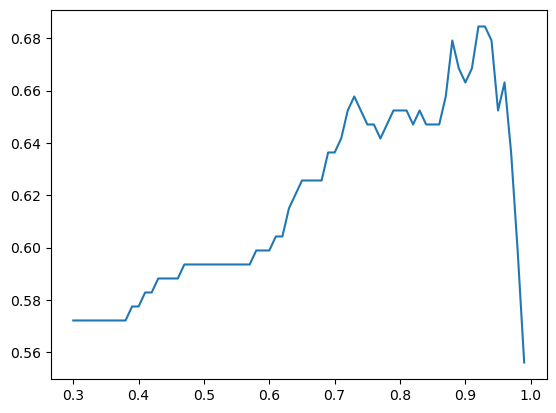

In [37]:
get_preds_mt("en->ru")

### Rus -> eng

['Джон и Энн нравятся друг другу.', 'Как у Тома с французским? - "Неплохо".', 'Я думаю, Тому нужно переодеться.', 'Был бы я канадец!', 'Одноклассники обзывали Тома.']
['John and Anne like each other.', 'How\'s Tom doing with French? - "Not bad".', 'I think Tom needs to change.', 'I wish I was Canadian!', 'The classmates called Tom.'] ['John and John are the only one of them.', 'How about Tom and French? - "Not bad."', "I think that's why you need to dress up.", 'I would be Canadian!', 'The classmates called Tom.']
SignificanceResult(statistic=0.594454285134068, pvalue=2.9839873938347707e-19)
0.7914438502673797


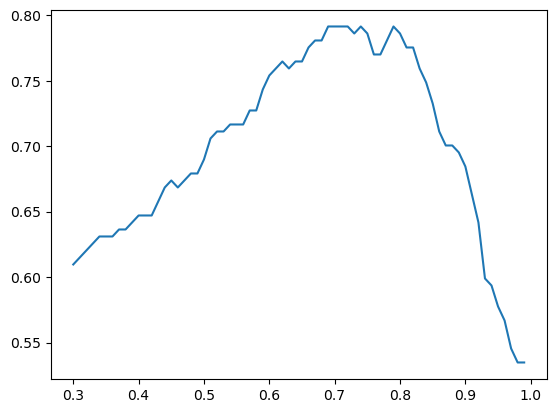

In [40]:
get_preds_mt("ru->en")

### LaBSE

In [19]:
import torch

def get_preds_mt_labse(mode):
    src_lang = "eng_Latn" if mode == "en->ru" else "rus_Cyrl"
    tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M", src_lang=src_lang)
    translator = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

    def translate(batch):
        lang = "rus_Cyrl" if mode == "en->ru" else "eng_Latn"
        inputs = tokenizer(batch, truncation=True, padding='max_length',max_length=30, return_tensors="pt").to("cuda:1")
        
        translated_tokens = translator.generate(
            **inputs, forced_bos_token_id=tokenizer.lang_code_to_id[lang], max_length=30
        )
        return tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)


    preds = []
    labels = []
    
    device = "cuda:1"
    model.to(device)
    translator.to(device)
    
    for batch in loader:
        src = batch["src"]
        hyp = batch["hyp"]

        if mode == "en->ru":
            hyp = translate(hyp)
        else:
            src = translate(src)

        hyp = labse_tokenizer(hyp, padding=True, truncation=True, max_length=64, return_tensors='pt').to(device)
        src = labse_tokenizer(src, padding=True, truncation=True, max_length=64, return_tensors='pt').to(device)
        
        with torch.no_grad():
            hyp_emb = get_embeddings(model(**hyp))
            src_emb = get_embeddings(model(**src))
    
        label = batch["label"]
        pred = cosine_similarity(hyp_emb, src_emb).cpu().detach()

        preds.extend(pred.numpy())
        labels.extend(label.numpy())

    print(spearmanr(labels, preds))

    accuracy_lst = []
    
    for threshold in np.arange(0.3, 1.0, 0.01):
        answers = [int(value) for value in np.array(preds) > threshold]
        accuracy_lst.append((np.array(labels) == np.array(answers)).mean())
    
    print(max(accuracy_lst))
    
    plt.plot(np.arange(0.3, 1.0, 0.01), accuracy_lst)

In [20]:
from transformers import AutoModel

labse_tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")

device = "cuda:1"
model.to(device)

def get_embeddings(output):
    return torch.nn.functional.normalize(output.pooler_output)

### Eng -> rus

SignificanceResult(statistic=0.516013988601004, pvalue=4.08324652569604e-14)
0.7540106951871658


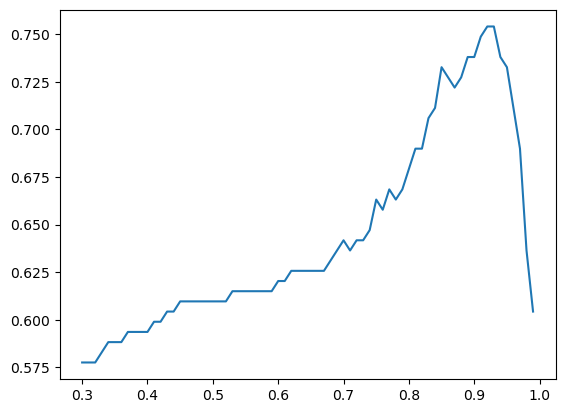

In [21]:
get_preds_mt_labse("en->ru")

### Rus -> eng

SignificanceResult(statistic=0.5647766787684982, pvalue=3.7912555186154384e-17)
0.7807486631016043


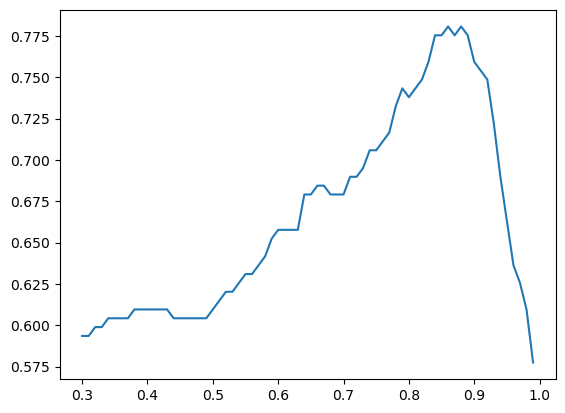

In [22]:
get_preds_mt_labse("ru->en")